# Evaluating the Model

### Install Requirements

In [1]:
%%capture

!pip install fiftyone
!pip install pyzbar
!pip install opencv-python
!pip install seaborn
!pip install openpyxl

### Import Required Libraries

In [2]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.data.catalog import Metadata
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer, ColorMode

import os
import sys
import numpy as np
import pandas as pd
import fiftyone as fo
from PIL import Image, ImageOps
from PIL.ExifTags import TAGS
from pathlib import Path
from pyzbar.pyzbar import decode
from pyzbar.pyzbar import ZBarSymbol
from torchvision import transforms
from IPython.display import display


### Specify Model

There are several output folders from training multiple models.  

In [51]:
# set this to today's date
today = "2024-03-14"

# modify output folder suffix if needed
suffix = "kfold_train"

# name of output folder
output_folder_name = today + "_" + suffix

data_path = '/home/jovyan/work/data/2024-03-14_leaves'
output_folder = f'/home/jovyan/work/mask_rcnn/{output_folder_name}'

k=5

# set up metadata
leaf_metadata = Metadata()
leaf_metadata.set(thing_classes = ['leaf', 'qr', 'red-square'])

namespace(thing_classes=['leaf', 'qr', 'red-square'])

In [52]:
import numpy as np
from PIL import Image, ImageOps
import fiftyone as fo

# Assuming leaf_predictor is defined elsewhere and dataset is an iterable of samples
datasets = {}

for fold in range(0, k):
    
    base_path = f"{output_folder}/fold_{fold}/"

    leaf_cfg = get_cfg()
    leaf_cfg.MODEL.DEVICE='cpu'
    leaf_cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
    leaf_cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3 
    leaf_cfg.MODEL.WEIGHTS = base_path + "model_final.pth" # path to trained weights
    leaf_cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7  # set a custom testing threshold

    leaf_predictor = DefaultPredictor(leaf_cfg)
    
    print(f'Loading fold {fold} into fiftyone dataset...')
    
    datasets[f'fold_{fold}'] = fo.Dataset.from_dir(
        data_path=f"{data_path}",
        labels_path=f"{output_folder}/test_{fold}.json",
        dataset_type=fo.types.COCODetectionDataset, 
        name=f"{today}_fold_{fold}",
        label_types="segmentations",
        overwrite=True
    )
    
    print(f'Performing inference for fold {fold}...')

    with fo.ProgressBar() as pb:
        for sample in pb(datasets[f'fold_{fold}']):
            image = Image.open(sample.filepath)
            image = ImageOps.exif_transpose(image)  # Ensure correct orientation
            image_arr = np.array(image)
            h, w, _ = image_arr.shape

            outputs = leaf_predictor(image_arr)

            # Initialize counters for each class
            red_square_pixels, leaf_pixels, qr_pixels = 0, 0, 0
            detections = []

            for i, (mask, box, label, score) in enumerate(zip(outputs["instances"].pred_masks.numpy(),
                                                              outputs["instances"].pred_boxes.tensor.numpy(),
                                                              outputs["instances"].pred_classes.numpy(),
                                                              outputs["instances"].scores.numpy())):
                x1, y1, x2, y2 = box
                rel_box = [x1 / w, y1 / h, (x2 - x1) / w, (y2 - y1) / h]  # Relative bounding box

                bbox_mask = mask[round(y1):round(y2), round(x1):round(x2)]
                mask_pixel_count = np.count_nonzero(bbox_mask)

                class_label = ['leaf', 'qr', 'red-square'][label]

                # Update pixel counts based on class
                if class_label == 'leaf':
                    leaf_pixels += mask_pixel_count
                elif class_label == 'red-square':
                    red_square_pixels += mask_pixel_count  # Assuming you want to sum red square pixels
                elif class_label == 'qr':
                    qr_pixels += mask_pixel_count

                detections.append(fo.Detection(
                    label=class_label,
                    bounding_box=rel_box,
                    mask=bbox_mask,
                    confidence=score,
                    original_bbox=box
                ))

            # print(f'image: {sample.filepath}, red_square_pixels: {red_square_pixels}, leaf_pixels: {leaf_pixels}, qr_pixels: {qr_pixels}')

            # Calculate leaf area
            leaf_area = None
            if red_square_pixels:
                # Red square is 2cm x 2cm, or 4 cm2
                leaf_area = (4 * leaf_pixels) / red_square_pixels
            elif qr_pixels:
                 # QR is 1.2cm x 1.2cm, or 1.44 cm2
                leaf_area = (1.44 * leaf_pixels) / qr_pixels

            # if leaf_area is not None:
            #     print(f'leaf area: {leaf_area:.2f} cm2')

            # Update sample with detections and calculated area
            sample["predictions"] = fo.Detections(detections=detections)
            sample["height"] = h
            sample["width"] = w
            sample["area"] = leaf_area
            sample.save()


[03/15 19:02:00 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /home/jovyan/work/mask_rcnn/2024-03-14_kfold_train/fold_0/model_final.pth ...
Loading fold 0 into fiftyone dataset...
 100% |███████████████████| 36/36 [9.2s elapsed, 0s remaining, 3.8 samples/s]      
Performing inference for fold 0...
 100% |███████████████████| 36/36 [1.0m elapsed, 0s remaining, 0.6 samples/s]     
[03/15 19:03:12 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /home/jovyan/work/mask_rcnn/2024-03-14_kfold_train/fold_1/model_final.pth ...
Loading fold 1 into fiftyone dataset...
 100% |███████████████████| 35/35 [8.2s elapsed, 0s remaining, 4.0 samples/s]      
Performing inference for fold 1...
 100% |███████████████████| 35/35 [59.6s elapsed, 0s remaining, 0.6 samples/s]    
[03/15 19:04:21 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /home/jovyan/work/mask_rcnn/2024-03-14_kfold_train/fold_2/model_final.pth ...
Loading fold

IMG_5858
Precision:  0
Recall:  0.0
Num matches: 0


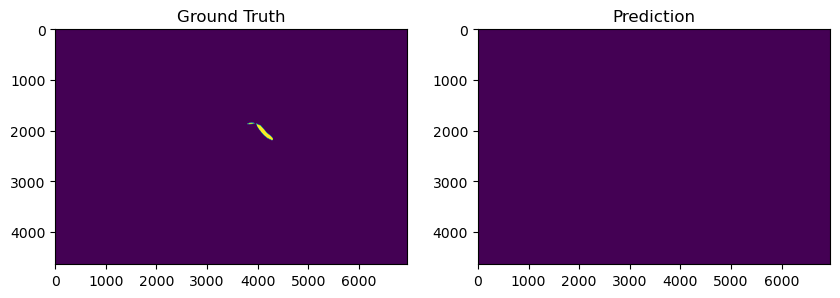

In [94]:
import numpy as np
import matplotlib.pyplot as plt

def convert_to_pixels(bbox, height, width):
    x1, y1, w, h = bbox
    return [x1 * width, y1 * height, (x1 + w) * width, (y1 + h) * height]

def calculate_mask(detections, height, width):
    mask = np.zeros((height, width), dtype=bool)
    for d in detections:
        if d.label == 'leaf':
            bbox = d.bounding_box
            x1, y1, x2, y2 = convert_to_pixels(bbox, height, width)
            mask[round(y1):round(y2), round(x1):round(x2)] |= d.mask
    return mask

def calculate_iou_and_dice(gt_mask, pred_mask):
    # if np.count_nonzero(gt_mask) == 0 and np.count_nonzero(pred_mask) == 0:
    #     # Perfect agreement in the absence of objects
    #     return 1, 1
    
    intersect = np.logical_and(gt_mask, pred_mask)
    union = np.logical_or(gt_mask, pred_mask)
    intersect_pixels = np.count_nonzero(intersect)
    union_pixels = np.count_nonzero(union)
    
    # Normal IoU and Dice calculation when there are objects
    iou = intersect_pixels / union_pixels if union_pixels else None
    dice = (2 * intersect_pixels) / (np.count_nonzero(gt_mask) + np.count_nonzero(pred_mask)) if np.count_nonzero(gt_mask) + np.count_nonzero(pred_mask) else None
    
    return iou, dice

def visualize_masks(gt_mask, pred_mask):
    f, axarr = plt.subplots(1, 2)
    plt.rcParams['figure.figsize'] = [10, 10]
    axarr[0].title.set_text('Ground Truth')
    axarr[1].title.set_text('Prediction')
    axarr[0].imshow(gt_mask)
    axarr[1].imshow(pred_mask)
    plt.show()
    

def calculate_precision_recall(ground_truths, predictions, iou_threshold=0.5):
    matches = []
    matched_gt_indices = set()  # To track which ground_truths are matched

    # Matching detections between predictions and ground_truths
    for pred in predictions:
        best_iou = 0
        best_match_index = None
        for index, gt in enumerate(ground_truths):
            iou, dice = calculate_iou_and_dice(gt['bounding_box'], pred['bounding_box'])
            if iou > best_iou:
                best_iou = iou
                best_match_index = index
        if best_iou >= iou_threshold:
            matches.append((pred, ground_truths[best_match_index]))
            matched_gt_indices.add(best_match_index)
        else:
            matches.append((pred, None))
    
    true_positives = len([match for match in matches if match[1] is not None])
    false_positives = len(predictions) - true_positives
    false_negatives = len(ground_truths) - len(matched_gt_indices)  # Ground truths not matched

    precision = true_positives / (true_positives + false_positives) if true_positives + false_positives > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if true_positives + false_negatives > 0 else 0

    return precision, recall, len(matches)


def calculate_precision_recall_unique(ground_truths, predictions, iou_threshold=0.5):
    # Filter detections to include only those with the label 'leaf'
    filtered_ground_truths = [gt for gt in ground_truths if gt['label'] == 'leaf']
    filtered_predictions = [pred for pred in predictions if pred['label'] == 'leaf']

    matches = []
    matched_gt_indices = set()  # Tracks which ground_truths are matched

    # Matching detections between filtered predictions and filtered ground_truths
    for pred_index, pred in enumerate(filtered_predictions):
        best_iou = 0
        best_match_index = None
        for gt_index, gt in enumerate(filtered_ground_truths):
            if gt_index in matched_gt_indices:
                continue  # Skip already matched ground truths

            iou, _ = calculate_iou_and_dice(gt['bounding_box'], pred['bounding_box'])  # Dice can be ignored if not needed
            if iou > best_iou:
                best_iou = iou
                best_match_index = gt_index
        
        if best_iou >= iou_threshold:
            matches.append((pred, filtered_ground_truths[best_match_index]))
            matched_gt_indices.add(best_match_index)
        else:
            matches.append((pred, None))
    
    true_positives = len([match for match in matches if match[1] is not None])
    false_positives = len(filtered_predictions) - true_positives
    false_negatives = len(filtered_ground_truths) - len(matched_gt_indices)
    


    # Keep the original print statements
    # print('True positives: ', true_positives)
    # print('False positives: ', false_positives)
    # print('False negatives: ', false_negatives)

    precision = true_positives / (true_positives + false_positives) if true_positives + false_positives > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if true_positives + false_negatives > 0 else 0

    return precision, recall, len(matches)



dataset_1 = datasets['fold_0']
# print(dataset_1)
sample = dataset_1.first()
height, width = sample.height, sample.width
ground_truth_mask = calculate_mask(sample.ground_truth.detections, height, width)
prediction_mask = calculate_mask(sample.predictions.detections, height, width)
filename = sample.filepath.split('/')[-1].split('.')[0]
print(filename)
precision, recall, num_matches = calculate_precision_recall_unique(sample.ground_truth.detections, sample.predictions.detections)
print('Precision: ', precision)
print('Recall: ', recall)
print('Num matches:', num_matches)

visualize_masks(ground_truth_mask, prediction_mask)
    

In [113]:
import pandas as pd

# initialize dataframe from manual area file, and add column for ml_area
df = pd.read_excel('/home/jovyan/work/data/manual_area.xlsx')

columns_to_initialize = ['ml_area', 'ground_truth_pixels', 'prediction_pixels', 'iou', 'dice', 'precision', 'recall', 'num_matches']

# Initialize columns to None and then convert to float
for column in columns_to_initialize:
    df[column] = None
    df[column] = df[column].astype(float)


missing_from_file = []

for fold_name, dataset in datasets.items():
    
    print('\n' + fold_name)
    print('---------------------------')
    
    fold_iou = []
    fold_dice = []

    for sample in dataset:

        filename = sample.filepath.split('/')[-1].split('.')[0]

        if not df.loc[df['picture'].str.startswith(filename)].empty:
            df.loc[df['picture'].str.startswith(filename), 'ml_area'] = float(round(sample.area, 2)) 
        else:
            missing_from_file.append(filename)
        
        height, width = sample.height, sample.width
        ground_truth_mask = calculate_mask(sample.ground_truth.detections, height, width)
        prediction_mask = calculate_mask(sample.predictions.detections, height, width)
        precision, recall, matches = calculate_precision_recall_unique(sample.ground_truth.detections, sample.predictions.detections)
        # print('\nPrecision (Positive Predictive Value): ', precision)
        # print('Recall (Sensitivity or True Positive Rate): ', recall)
        # print('# matches: ', matches)

        # print('Prediction pixel count: ', np.count_nonzero(prediction_mask))
        # print('Ground truth pixel count: ', np.count_nonzero(ground_truth_mask))
        print(filename)

        iou, dice = calculate_iou_and_dice(ground_truth_mask, prediction_mask)
 
        
        # print(dice)
        
        df.loc[df['picture'].str.startswith(filename), 'ground_truth_pixels'] = np.count_nonzero(ground_truth_mask)
        df.loc[df['picture'].str.startswith(filename), 'prediction_pixels'] = np.count_nonzero(prediction_mask)
        df.loc[df['picture'].str.startswith(filename), 'iou'] = round(iou, 3) if iou is not None else None
        df.loc[df['picture'].str.startswith(filename), 'dice'] = round(dice, 3) if dice is not None else None
        df.loc[df['picture'].str.startswith(filename), 'precision'] = round(precision, 3)
        df.loc[df['picture'].str.startswith(filename), 'recall'] = round(recall, 3)
        df.loc[df['picture'].str.startswith(filename), 'num_matches'] = matches  
        
        fold_iou.append(iou)
        fold_dice.append(dice)

#         visualize_masks(ground_truth_mask, prediction_mask)
    
    fold_iou = np.array(fold_iou, dtype=float)
   

    print('Min IOU: ', np.nanmin(fold_iou))
    print('Max IOU: ', np.nanmax(fold_iou))
    print('Average IOU: ', np.nanmean(fold_iou))

    print('\n')
    # print(fold_dice)
    fold_dice = np.array(fold_dice, dtype=float)
    # print(fold_dice)

    print('Min Dice: ', np.nanmin(fold_dice))
    print('Max Dice: ', np.nanmax(fold_dice))
    print('Average Dice: ', np.nanmean(fold_dice))


# df_area = df[df['ml_area'] >= 0.0]
pd.set_option('display.max_rows', None)  # None means unlimited
pd.set_option('display.max_columns', None)
print(df)

# Calculate means for specific columns
mean_values = {
    'ground_truth_pixels': None,
    'prediction_pixels': None,
    'iou': np.nanmean(df['iou']),
    'dice': np.nanmean(df['dice']),
    'precision': df['precision'].mean(),
    'recall': df['recall'].mean(),
    'num_matches': None,
}

# Create a new DataFrame with the mean values
mean_df = pd.DataFrame(mean_values, index=['average'])

# Append the new DataFrame with averages to the original DataFrame
df = pd.concat([df, mean_df])


# Specify the path and name of the CSV file you want to create
csv_file_path = f'{output_folder}/{output_folder_name}.csv'

# Export the DataFrame to CSV
df.to_csv(csv_file_path, index=False)



fold_0
---------------------------
IMG_5858
IMG_5869
IMG_5871
IMG_5879
IMG_5908
IMG_5918
IMG_5924
IMG_5951
IMG_5957
IMG_5958
IMG_5959
IMG_5962
IMG_5970
IMG_5973
IMG_5976
IMG_5984
IMG_5985
IMG_5990
IMG_5993
IMG_5997
IMG_5998
IMG_6000
IMG_6001
IMG_6002
IMG_6008
IMG_6009
IMG_6010
IMG_6019
IMG_6035
IMG_6037
IMG_6039
IMG_6041
IMG_6043
IMG_6047
IMG_6050
IMG_6055
Min IOU:  0.0
Max IOU:  0.91703888663855
Average IOU:  0.6350213606639696


Min Dice:  0.0
Max Dice:  0.9567243450617119
Average Dice:  0.7019369279547062

fold_1
---------------------------
IMG_5850
IMG_5856
IMG_5862
IMG_5873
IMG_5874
IMG_5875
IMG_5910
IMG_5913
IMG_5914
IMG_5919
IMG_5922
IMG_5925
IMG_5933
IMG_5935
IMG_5936
IMG_5937
IMG_5938
IMG_5939
IMG_5947
IMG_5953
IMG_5955
IMG_5968
IMG_5969
IMG_5971
IMG_5972
IMG_5978
IMG_5987
IMG_5995
IMG_6016
IMG_6024
IMG_6027
IMG_6028
IMG_6034
IMG_6040
IMG_6042
Min IOU:  0.0
Max IOU:  0.909409726952494
Average IOU:  0.5640881511176132


Min Dice:  0.0
Max Dice:  0.9525558753740654
Average Dice

/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


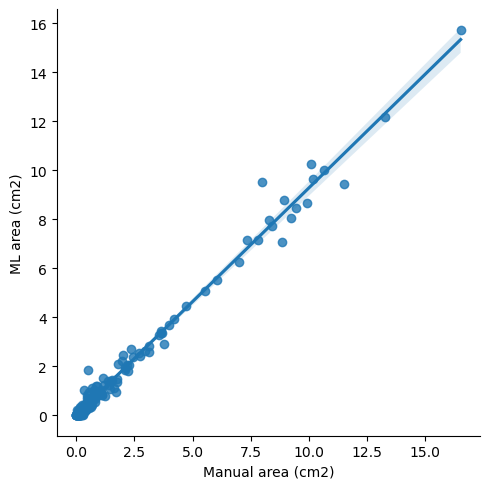

In [96]:
import seaborn as sns
plt = sns.lmplot(data=df_area, x='area_cm2', y='ml_area', fit_reg=True)
plt.set(xlabel='Manual area (cm2)', ylabel='ML area (cm2)')

In [12]:
df_area.corr(numeric_only=True)

,area_cm2,ml_area,ground_truth_pixels,prediction_pixels,iou,dice
area_cm2,1.000000,0.996405,0.966514,0.961959,0.301014,0.246962
ml_area,0.996405,1.000000,0.957132,0.959170,0.343049,0.291463
ground_truth_pixels,0.966514,0.957132,1.000000,0.995503,0.295543,0.239145
prediction_pixels,0.961959,0.959170,0.995503,1.000000,0.348846,0.296152
iou,0.301014,0.343049,0.295543,0.348846,1.000000,0.988568
dice,0.246962,0.291463,0.239145,0.296152,0.988568,1.000000


In [13]:
from scipy import stats

corr = stats.pearsonr(df_area.area_cm2, df_area.ml_area)
print(corr)
r_squared = corr.statistic * corr.statistic
print('r^2:', r_squared)

PearsonRResult(statistic=0.9964054448825971, pvalue=1.218990797277069e-74)
r^2: 0.9928238105916862


In [14]:
df_area.corr(method='pearson', numeric_only=True)

,area_cm2,ml_area,ground_truth_pixels,prediction_pixels,iou,dice
area_cm2,1.000000,0.996405,0.966514,0.961959,0.301014,0.246962
ml_area,0.996405,1.000000,0.957132,0.959170,0.343049,0.291463
ground_truth_pixels,0.966514,0.957132,1.000000,0.995503,0.295543,0.239145
prediction_pixels,0.961959,0.959170,0.995503,1.000000,0.348846,0.296152
iou,0.301014,0.343049,0.295543,0.348846,1.000000,0.988568
dice,0.246962,0.291463,0.239145,0.296152,0.988568,1.000000


In [15]:
df_area.corr(method='kendall', numeric_only=True)

,area_cm2,ml_area,ground_truth_pixels,prediction_pixels,iou,dice
area_cm2,1.000000,0.785138,0.928849,0.750789,0.416334,0.416334
ml_area,0.785138,1.000000,0.740572,0.943136,0.578163,0.578163
ground_truth_pixels,0.928849,0.740572,1.000000,0.762382,0.439054,0.439054
prediction_pixels,0.750789,0.943136,0.762382,1.000000,0.599069,0.599069
iou,0.416334,0.578163,0.439054,0.599069,1.000000,1.000000
dice,0.416334,0.578163,0.439054,0.599069,1.000000,1.000000


In [16]:
session = fo.launch_app(dataset, port=5151, address="0.0.0.0")


Welcome to

███████╗██╗███████╗████████╗██╗   ██╗ ██████╗ ███╗   ██╗███████╗
██╔════╝██║██╔════╝╚══██╔══╝╚██╗ ██╔╝██╔═══██╗████╗  ██║██╔════╝
█████╗  ██║█████╗     ██║    ╚████╔╝ ██║   ██║██╔██╗ ██║█████╗
██╔══╝  ██║██╔══╝     ██║     ╚██╔╝  ██║   ██║██║╚██╗██║██╔══╝
██║     ██║██║        ██║      ██║   ╚██████╔╝██║ ╚████║███████╗
╚═╝     ╚═╝╚═╝        ╚═╝      ╚═╝    ╚═════╝ ╚═╝  ╚═══╝╚══════╝ v0.23.6

If you're finding FiftyOne helpful, here's how you can get involved:

|
|  ⭐⭐⭐ Give the project a star on GitHub ⭐⭐⭐
|  https://github.com/voxel51/fiftyone
|
|  🚀🚀🚀 Join the FiftyOne Slack community 🚀🚀🚀
|  https://slack.voxel51.com
|



In [ ]:
session.refresh()